# Quick Regression

Let's see if we can predict something terribly!

In [206]:
# Bring in data
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Import LinearRegression
from sklearn.linear_model import LinearRegression
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# Split the data
from sklearn.model_selection import train_test_split
# Optimize Parameters
from sklearn.model_selection import RandomizedSearchCV
# Import RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# Import GradientBoosted
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
# Import xgboost
import xgboost as xgb
# Import RSME
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
# Import Classification metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
# Import scaling and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)

In [289]:
pitcher_all[pitcher_all.Year < 2017].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 0 to 970
Data columns (total 25 columns):
Age                 938 non-null int64
WAR_3               938 non-null float64
nameFirst           938 non-null object
nameLast            938 non-null object
Year                938 non-null int64
Dollars             497 non-null float64
Length              938 non-null int64
playerID            938 non-null object
yearID              938 non-null int64
ERA                 938 non-null float64
WHIP                938 non-null float64
K_9                 938 non-null float64
HR_9                938 non-null float64
IPouts              938 non-null float64
W                   938 non-null float64
SV                  938 non-null float64
Med_WAR             938 non-null float64
Min_WAR             938 non-null float64
Inflation_Factor    938 non-null float64
Total               938 non-null float64
Dollars_2006        497 non-null float64
Pos_RP              938 non-null uint8
Pos_SP

In [288]:
position_all[position_all.Year < 2017].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1004 entries, 0 to 1003
Data columns (total 31 columns):
Age                 1004 non-null int64
WAR_3               1004 non-null float64
nameFirst           1004 non-null object
nameLast            1004 non-null object
Year                1004 non-null int64
Dollars             554 non-null float64
Length              1004 non-null int64
playerID            1004 non-null object
yearID              1004 non-null int64
G                   1004 non-null float64
OBP                 1004 non-null float64
SLG                 1004 non-null float64
HR                  1004 non-null float64
RBI                 1004 non-null float64
SB                  1004 non-null float64
Med_WAR             1004 non-null float64
Min_WAR             1004 non-null float64
Inflation_Factor    1004 non-null float64
Total               1004 non-null float64
Dollars_2006        554 non-null float64
Pos_1B              1004 non-null uint8
Pos_2B              1004 n

In [290]:
# Compute total contract percentage
(497 + 554)/(938 + 1004)

0.5411946446961895

In [209]:
# Bring in models
lm = LinearRegression()
logr = LogisticRegression()
rf = RandomForestRegressor()
rfc = RandomForestClassifier()
gbr = GradientBoostingRegressor()
gbc = GradientBoostingClassifier()
xgr = xgb.XGBRegressor()
xgc = xgb.XGBClassifier()

In [210]:
# Create position one-hot configuration
position_all = pd.get_dummies(position_all, columns = ['Position'], prefix= ['Pos'])
pitcher_all = pd.get_dummies(pitcher_all, columns = ['Position'], prefix= ['Pos'])

# Create Contract logical variable
position_all['Contract'] = position_all.Dollars.notnull()
pitcher_all['Contract'] = pitcher_all.Dollars.notnull()

# Create AAV variable
position_all['AAV'] = position_all.Dollars_2006.divide(position_all.Length)
pitcher_all['AAV'] = pitcher_all.Dollars_2006.divide(pitcher_all.Length)
# Remove 2017 data
position_data = position_all[position_all.Year < 2017]
pitcher_data = pitcher_all[pitcher_all.Year < 2017]

# Designate interesting columns
features_pos = ['Age', 'WAR_3', 'G', 'OBP', 'SLG', 'HR', 'RBI', 'SB',
                'Med_WAR', 'Min_WAR', 'Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B',
                'Pos_SS', 'Pos_LF', 'Pos_CF', 'Pos_RF', 'Pos_DH']
features_pitch = ['Age', 'WAR_3', 'ERA', 'WHIP', 'K_9', 'HR_9', 'IPouts',
                  'W', 'SV', 'Med_WAR', 'Min_WAR', 'Pos_SP', 'Pos_RP']

print(position_all['Length'].value_counts())
print(position_all.shape)

0     495
1     378
2     120
3      50
4      23
5      13
7       6
6       4
10      3
8       3
9       1
Name: Length, dtype: int64
(1096, 31)


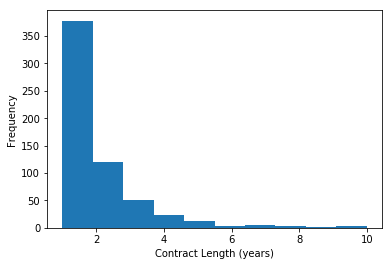

In [211]:
position_has = position_all[position_all.Length > 0]

position_has['Length'].plot(kind = 'hist', bins = 10)
plt.xlabel('Contract Length (years)')
plt.savefig('length_hist.png')
plt.show()

In [212]:
position_has['Length'].value_counts()

1     378
2     120
3      50
4      23
5      13
7       6
6       4
10      3
8       3
9       1
Name: Length, dtype: int64

In [213]:
378/599

0.6310517529215359

In [214]:
pred_acc_theo = 378/ (1096-497)
pred_acc_theo

0.6310517529215359

## Predict yes/no on who will get a contract

In [215]:
# Position players first
# Grab just the features and the outcome
X_pos = position_data[features_pos].values
y_contract_pos = position_data['Contract'].values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_pos, y_contract_pos, random_state = 20, test_size = 0.1)

# Use the logr model
logr.fit(X_train, y_train)

print(logr.score(X_test, y_test))

y_pred = logr.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.722772277228
             precision    recall  f1-score   support

      False       0.71      0.71      0.71        48
       True       0.74      0.74      0.74        53

avg / total       0.72      0.72      0.72       101

[[34 14]
 [14 39]]


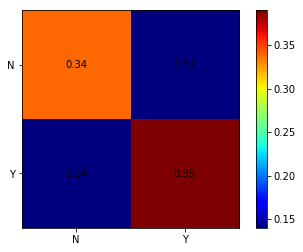

In [216]:
mtx_rfc_pos = np.round(confusion_matrix(y_test, y_pred)/len(y_test), decimals = 2)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(mtx_rfc_pos), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = mtx_rfc_pos.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(mtx_rfc_pos[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
        

cb = fig.colorbar(res)
alphabet = 'NY'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])        
plt.savefig('colormap.png')
plt.show()

In [217]:
#Import necessary modules
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc_score = roc_auc_score(y_test, y_pred_prob)
auc_score

0.82154088050314467

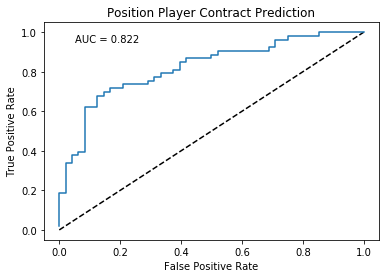

In [218]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(x = 0.05, y = 0.95, s = "AUC = {:0.3f}".format(auc_score))
plt.title('Position Player Contract Prediction')
plt.savefig('./ROC_curve.png')
plt.show()

In [219]:
# Try random forest
rfc.fit(X_train, y_train)

print(rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.762376237624
             precision    recall  f1-score   support

      False       0.73      0.79      0.76        48
       True       0.80      0.74      0.76        53

avg / total       0.76      0.76      0.76       101

[[38 10]
 [14 39]]


In [220]:
# Try gradient boosting
gbc.fit(X_train, y_train)

print(gbc.score(X_test, y_test))

y_pred = gbc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.732673267327
             precision    recall  f1-score   support

      False       0.73      0.69      0.71        48
       True       0.73      0.77      0.75        53

avg / total       0.73      0.73      0.73       101

[[33 15]
 [12 41]]


In [221]:
# Now pitchers

# Grab just the features and the outcome
X_pitch = pitcher_data[features_pitch].values
y_contract_pitch = pitcher_data['Contract'].values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_pitch, y_contract_pitch, random_state = 20, test_size = 0.1)

# Use the logr model
logr.fit(X_train, y_train)

print(logr.score(X_test, y_test))

y_pred = logr.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.808510638298
             precision    recall  f1-score   support

      False       0.78      0.85      0.81        46
       True       0.84      0.77      0.80        48

avg / total       0.81      0.81      0.81        94

[[39  7]
 [11 37]]


In [222]:
# Try random forest
rfc.fit(X_train, y_train)

print(rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.723404255319
             precision    recall  f1-score   support

      False       0.69      0.78      0.73        46
       True       0.76      0.67      0.71        48

avg / total       0.73      0.72      0.72        94

[[36 10]
 [16 32]]


In [223]:
# Try gradient boosting
gbc.fit(X_train, y_train)

print(gbc.score(X_test, y_test))

y_pred = gbc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.787234042553
             precision    recall  f1-score   support

      False       0.78      0.78      0.78        46
       True       0.79      0.79      0.79        48

avg / total       0.79      0.79      0.79        94

[[36 10]
 [10 38]]


## Functions for creating predictions for a year given that year

For now, these will use an OOTB gradient boosted model

In [308]:
# Define function for Dollars
def predictDollars(regressor, X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = 0.1)
    
    # Setup the pipeline steps: steps
    steps = [('scaler', StandardScaler()),
        ('model', regressor)]
    
    model = Pipeline(steps)
         
    # Train the model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Compute percent error
    percent_error = 100* np.absolute((y_pred - y_test)/y_test)
    
    mpe = np.median(percent_error)

    plt.scatter(y_test, y_pred, color = 'blue')
    plt.plot(y_test, y_test, color = 'k')
    plt.xlabel('Actual Average Dollars (millions)')
    plt.ylabel('Predicted Average Dollars (millions)')
    plt.title('Prediction Contract Value')
    plt.yticks([0,5e6,1e7,1.5e7,2e7],['0','5','10','15','20'])
    plt.xticks([0,5e6,1e7,1.5e7,2e7],['0','5','10','15','20'])
    plt.text(x = 0, y = 1.6e7, s = "Median Error = {:0.1f}%".format(mpe))
    plt.savefig('./contract_dollars_regression.png')
    plt.show()

    return mpe, rmse, model

In [230]:
# Definte function for contract length
def predictLength(model, X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    plt.scatter(y_test, y_test, color = 'red')

    plt.xlabel('Predicted Contract Length (years)')

    plt.ylabel('Actual Contract Length (years)')

    plt.title('Prediction Contract Length')
    plt.text(x = 1, y = 7, s = "R^2 = {:0.3f}".format(model.score(X_test, y_test)))
    #plt.savefig('./contract_length_regression.png')
    plt.show()

    return model.score(X_test, y_test), f1_score(y_test, y_pred, average = 'micro'), confusion_matrix(y_test, y_pred)

# First Task: Predict Yes/No on contract

We'll use a binary classifier (starting with Logistic Regression and moving on if needed) to:

1. Classify position players into "Yes/No" on contract
2. Classify pitchers into "Yes/No" on contract
3. Run RandomizedSearchCV to determine best parameters for each model


## Attempt 1: Batting Data w/ Team WAR

Woo!

### Step 1: Predict which players will get contracts

In [279]:
# For now, simulate dropping these
pitcher_trimmed = position_data.dropna()

### Step 2: Predict how big the contracts will be

Make 2 models, and do it in 2006 dollars

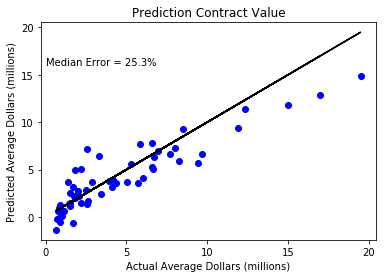

In [309]:
# Grab just the features and the outcome
X_pos = pitcher_trimmed[features_pos].values
y_dollars_pos = pitcher_trimmed['AAV'].values
y_length_pos = pitcher_trimmed['Length'].values
r_lm_pos, score_lm_pos, model_lm_pos = predictDollars(lm, X_pos, y_dollars_pos)

In [281]:
rmse = score_lm_pos

In [282]:
mean_dollars = np.mean(y_dollars_pos)

In [283]:
rmse/mean_dollars

0.43930458832901764

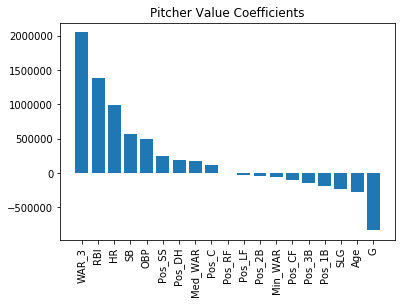

In [284]:
# Extract the coefficients
coefficients = model_lm_pos.named_steps['model'].coef_
idx = np.flip(np.argsort(coefficients), 0)
labels =np.array(features_pos)
plt.figure()
plt.bar(list(range(len(coefficients))),coefficients[idx])
#plt.xticks(list(range(len(coefficients))), '')
plt.xticks(list(range(len(coefficients))), labels[idx], rotation='vertical')
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
 #   which='both',      # both major and minor ticks are affected
 #   bottom='off',      # ticks along the bottom edge are off
 #   top='off',         # ticks along the top edge are off
 #   labelbottom='off') # labels along the bottom edge are off
plt.title('Pitcher Value Coefficients')
plt.savefig('pitcher_coefficient_plot.png')
plt.show()

# For next week: 
## Point out the WAR/Age/RBIs?
## For positions, point out SS, 1B

In [250]:
idx = np.flip(np.argsort(coefficients), 0)
print(np.flip(coefficients[idx], 0))
print(labels[idx])

[ -8.33683638e+05  -2.81835539e+05  -2.40046909e+05  -1.96309194e+05
  -1.46330524e+05  -1.00585952e+05  -6.11356746e+04  -4.59088741e+04
  -3.45946695e+04  -5.23533034e+02   1.16491859e+05   1.75530641e+05
   1.89062357e+05   2.49255487e+05   4.96286167e+05   5.73175985e+05
   9.86756246e+05   1.38696837e+06   2.04792893e+06]
['WAR_3' 'RBI' 'HR' 'SB' 'OBP' 'Pos_SS' 'Pos_DH' 'Med_WAR' 'Pos_C' 'Pos_RF'
 'Pos_LF' 'Pos_2B' 'Min_WAR' 'Pos_CF' 'Pos_3B' 'Pos_1B' 'SLG' 'Age' 'G']


In [136]:
mlb_tr_2016 = {'Yoenis Cespedes': (5, 125e6),
               'Edwin Encarnacion': (4, 92e6),
               'Aroldis Chapman': (5, 90e6),
               'Justin Turner': (5, 85e6),
               'Kenley Jansen': (5, 85e6),
               'Dexter Fowler': (4, 64e6),
               'Jeremy Hellickson': (4, 60e6),
               'Mark Trumbo': (4, 60e6),
               'Ian Desmond': (4, 60e6), 
               'Ivan Nova': (4, 52e6),
               'Mark Melancon': (4, 52e6),
               'Jose Bautista': (3, 51e6),
               'Wilson Ramos': (4, 50e6),
               'Rich Hill': (3, 50e6),
               'Jason Hammel': (3, 42e6),
               'Matt Wieters': (4, 39e6),
               'Josh Reddick': (3, 36e6),
               'Neil Walker': (3, 36e6),
               'Carlos Gomez': (3, 36e6),
               'Michael Saunders': (3, 33e6),
               'Mike Napoli': (2, 28e6),
               'Kendrys Morales': (2, 26e6),
               'Greg Holland': (2, 18e6),
               'Travis Wood': (3, 21e6),
               'Neftali Feliz': (3, 18e6),
               'Brett Cecil': (3, 18e6),
               'Brad Ziegler': (2, 16e6),
               'Andrew Cashner': (1, 8e6),
               'Jason Castro': (2, 15e6),
               'Brandon Moss': (2, 14e6),
               'Luis Valbuena': (2, 14e6),
               'Joe Blanton': (2, 14e6),
               'Carlos Beltran': (1, 14e6),
               'Sergio Romo': (2, 14e6),
               'Sean Rodriguez': (2, 12e6),
               'Santiago Casilla': (2, 12e6),
               'Jon Jay': (2, 12e6),
               'Fernando Salas': (2, 12e6),
               'Boone Logan': (2, 12e6),
               'Matt Holliday': (1, 10e6),
               'Bartolo Colon': (1, 10e6), 
               'Steve Pearce': (2, 10e6), 
               'Matt Joyce': (2, 10e6),
               'Nick Hundley': (2, 10e6),
               'Eric Thames': (2, 10e6), 
               'Charlie Morton': (1, 8e6),
               'Edinson Volquez': (1, 8e6),
               'R.A. Dickey': (1, 8e6),
               'Chase Utley': (1, 8e6),
               'Derek Holland': (1, 6e6)
              }

In [140]:
mlb_tr_2016['Yoenis Cespedes'][1]/mlb_tr_2016['Yoenis Cespedes'][0]

25000000.0

In [159]:
# Make lists and then a DF of the information

nameFirst = []
nameLast = []
aav = []

for name, contract in mlb_tr_2016.items():
    aav.append(contract[1]/contract[0])
    name_split = name.split(' ')
    nameFirst.append(name_split[0])
    nameLast.append(name_split[1])
    
mlbtr_df = pd.DataFrame({'nameFirst': nameFirst,
              'nameLast': nameLast,
              'dollars_mlbtr' : aav})

In [160]:
# Make the predictions for 2016
import models

fa_year = 2016

# Load and prepare the datasets                                                                                                                                                             
#pitcher_all, position_all = models.loadAllData()
with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)


pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
position_prepped = models.prepareFreeAgentData(position_all)

# Use year to split dataset into 2016 and all others                                                                                                                                                                
X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch = models.splitDataByYear(pitcher_prepped, fa_year, 'pitcher')
X_train_pos, y_train_pos, X_test_pos, y_test_pos = models.splitDataByYear(position_prepped, fa_year, 'position')

# Predict whether they'll get contracts                                                                                                                                                     
contract_model_pitch, contract_pitch = models.predictContract(X_train_pitch, y_train_pitch, X_test_pitch)
contract_model_pos, contract_pos = models.predictContract(X_train_pos, y_train_pos, X_test_pos)

# Predict contract dollars                                                                                                                                                                  
dollars_model_pitch, dollars_pitch = models.predictDollars(X_train_pitch, y_train_pitch, X_test_pitch)
dollars_model_pos, dollars_pos = models.predictDollars(X_train_pos, y_train_pos, X_test_pos)

In [172]:
inflation_factor = pitcher_prepped[pitcher_prepped.Year == fa_year]['Inflation_Factor'].unique()[0]

pitcher_preds = pd.DataFrame({'nameFirst' : pitcher_prepped[pitcher_prepped.Year == fa_year]['nameFirst'].values,
              'nameLast' : pitcher_prepped[pitcher_prepped.Year == fa_year]['nameLast'].values,
              'contract_pred' : contract_pitch,
              'contract_actual' : y_test_pitch['Contract'],
              'dollars_pred' : np.round(dollars_pitch * inflation_factor, decimals = -5),
              'dollars_actual' : np.round(y_test_pitch['AAV_2006'] * inflation_factor, decimals = -5)})

position_preds = pd.DataFrame({'nameFirst' : position_prepped[position_prepped.Year == fa_year]['nameFirst'].values,
              'nameLast' : position_prepped[position_prepped.Year == fa_year]['nameLast'].values,
              'contract_pred' : contract_pos,
              'contract_actual' : y_test_pos['Contract'],
              'dollars_pred' : np.round(dollars_pos * inflation_factor, decimals = -5),
              'dollars_actual' : np.round(y_test_pos['AAV_2006'] * inflation_factor, decimals = -5)})

full_df = pd.concat([pitcher_preds, position_preds])

## Make contract_pred values true
full_df.loc[full_df.contract_pred == False,'dollars_pred'] = 0

In [173]:
# Merge the two
merged_preds = pd.merge(full_df, mlbtr_df, on = ['nameFirst', 'nameLast'], suffixes = ['_BC','_TR'])
merged_preds

,contract_actual,contract_pred,dollars_actual,dollars_pred,nameFirst,nameLast,dollars_mlbtr
0,True,True,4000000.0,6900000.0,Joe,Blanton,7.000000e+06
1,True,True,3000000.0,3600000.0,Sergio,Romo,7.000000e+06
2,True,True,3000000.0,4400000.0,Fernando,Salas,6.000000e+06
3,True,True,6000000.0,3700000.0,Travis,Wood,7.000000e+06
4,True,True,5500000.0,4700000.0,Boone,Logan,6.000000e+06
5,True,True,5500000.0,10000000.0,Santiago,Casilla,6.000000e+06
6,True,True,5400000.0,5100000.0,Neftali,Feliz,6.000000e+06
7,True,True,16000000.0,18200000.0,Kenley,Jansen,1.700000e+07
8,True,True,8000000.0,9100000.0,Brad,Ziegler,8.000000e+06
9,True,True,17200000.0,18300000.0,Aroldis,Chapman,1.800000e+07


In [188]:
my_rmse = np.sqrt(mean_squared_error(merged_preds.dollars_actual.values, 
                             merged_preds.dollars_pred.values))
tr_rmse = np.sqrt(mean_squared_error(merged_preds.dollars_actual.values,
                             merged_preds.dollars_mlbtr.values))
print("My RMSE: {0:1.2E}".format(my_rmse))
print("Their RMSE: {0:1.2E}".format(tr_rmse))

My RMSE: 3.49E+06
Their RMSE: 2.57E+06


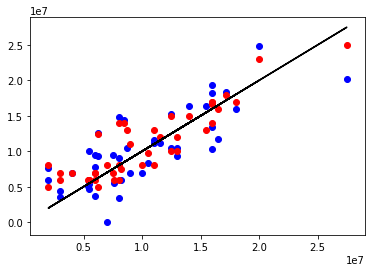

In [186]:
plt.plot(merged_preds.dollars_actual.values,merged_preds.dollars_actual.values, color = 'k')
plt.scatter(merged_preds.dollars_actual.values, merged_preds.dollars_pred.values, color = 'b')
plt.scatter(merged_preds.dollars_actual.values, merged_preds.dollars_mlbtr.values, color = 'r')
plt.show()


## Try Random Forest...now let's add Position to the matrix!

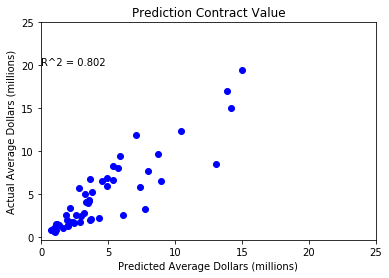

In [63]:
r_rfr_pos, score_rfr_pos = predictDollars(rf, X_pos, y_dollars_pos)

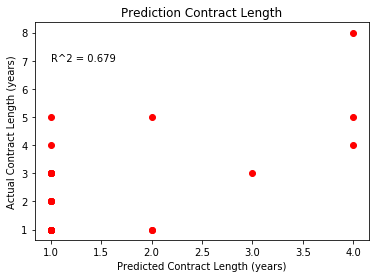

In [64]:
r_rfc_pos, score_rfc_pos, mtx_rfc_pos = predictLength(rfc, X_pos, y_length_pos)

In [65]:
pd.DataFrame({'Values':y_)

SyntaxError: invalid syntax (<ipython-input-65-7a1e078de456>, line 1)

In [66]:
mtx_rfc_pos

array([[36,  2,  0,  0,  0,  0],
       [ 5,  0,  0,  0,  0,  0],
       [ 6,  0,  1,  0,  0,  0],
       [ 1,  0,  0,  1,  0,  0],
       [ 1,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0]])

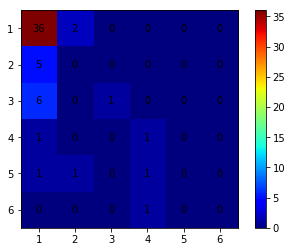

In [68]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(mtx_rfc_pos), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = mtx_rfc_pos.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(mtx_rfc_pos[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
        

cb = fig.colorbar(res)
alphabet = '123456'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])        
plt.savefig('colormap.png')
plt.show()

## Try it for pitchers; straight to RF + LM!

In [105]:
# For now, simulate dropping these
pitcher_trimmed = pitcher_data.dropna()

X_pitch = pitcher_trimmed[features_pitch].values
y_dollars_pitch = pitcher_trimmed['AAV'].values
y_length_pitch = pitcher_trimmed['Length'].values

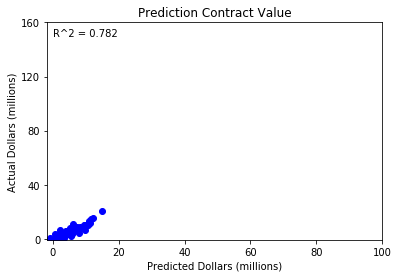

In [184]:
# Try the LM
r_lm_pitch, score_lm_pitch = predictDollars(lm, X_pitch, y_dollars_pitch)

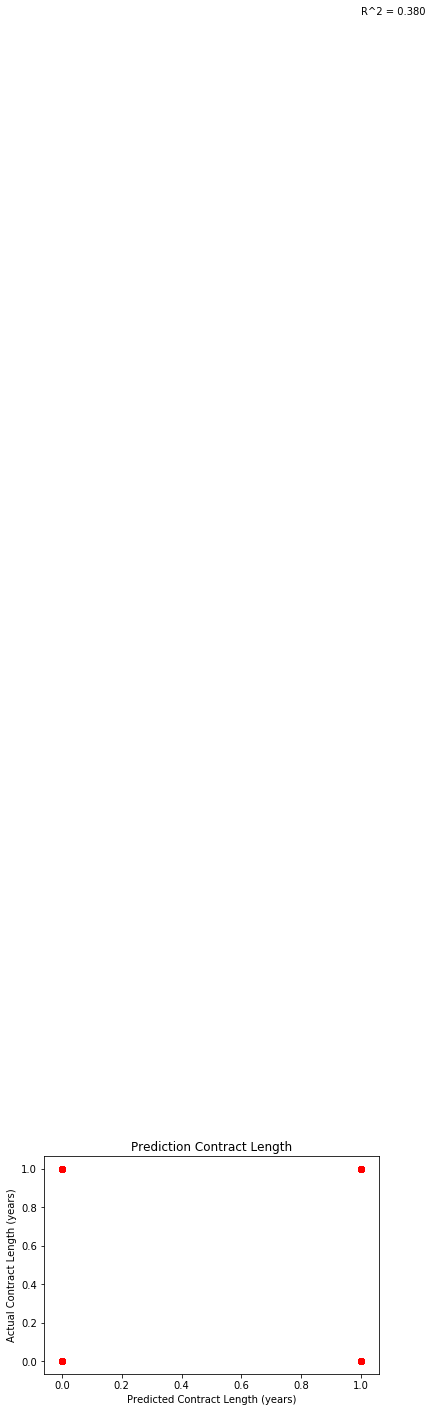

In [185]:
y_dummies  = pd.get_dummies(y_length_pitch)

r_log_pitch, score_log_pitch = predictLength(logr, X_pitch, y_dummies)

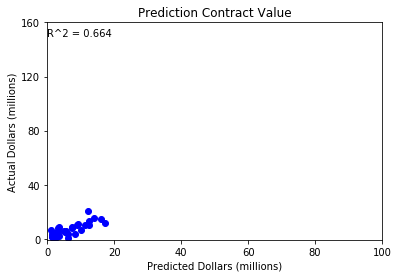

In [186]:
# Try RF
r_rfr_pitch, score_rfr_pitch = predictDollars(rf, X_pitch, y_dollars_pitch)

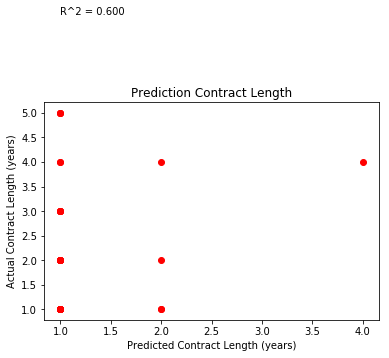

In [187]:
r_rfc_pitch, score_rfc_pitch = predictLength(rfc, X_pitch, y_length_pitch)

## Try boosting (sklearn)

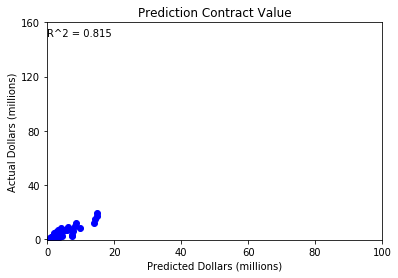

In [188]:
r_gbr_pos, score_gbr_pos = predictDollars(gbr, X_pos, y_dollars_pos)

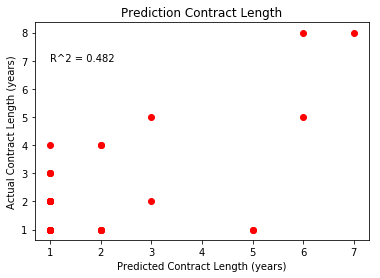

In [189]:
r_gbc_pos, score_gbc_pos = predictLength(gbc, X_pos, y_length_pos)

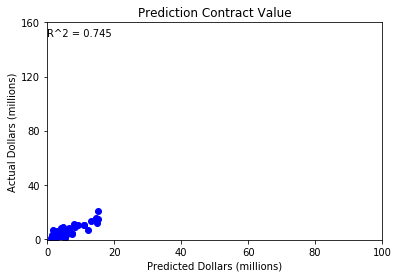

In [190]:
r_gbr_pitch, score_gbr_pitch = predictDollars(gbr, X_pitch, y_dollars_pitch)

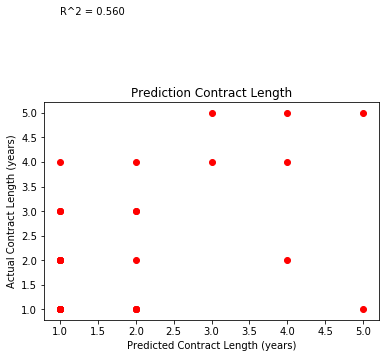

In [191]:
r_gbc_pitch, score_gbc_pitch = predictLength(gbc, X_pitch, y_length_pitch)

In [192]:
RMSE = np.array([score_lm_pos, score_lm_pitch, score_rfr_pos, score_rfr_pitch, score_gbr_pos, score_gbr_pitch])
R_squared = [r_lm_pos, r_lm_pitch, r_rfr_pos, r_rfr_pitch, r_gbr_pos, r_gbr_pitch]
labels = ['Position_LM', 'Pitcher_LM', 'Position_RF', 'Pitcher_RF', 'Position_GB', 'Pitcher_GB']

pd.DataFrame({'Model Type' : labels,
              'RMSE' : RMSE/1e6,
              'R^2' : R_squared
             })

,Model Type,RMSE,R^2
0,Position_LM,1.820747,0.814735
1,Pitcher_LM,2.025157,0.782372
2,Position_RF,2.048792,0.765420
3,Pitcher_RF,2.516163,0.664050
4,Position_GB,1.818103,0.815272
5,Pitcher_GB,2.193165,0.744765


In [194]:
f1 = np.array([score_log_pos, score_log_pitch, score_rfc_pos, score_rfc_pitch, score_gbc_pos, score_gbc_pitch])
Acc = [r_log_pos, r_log_pitch, r_rfc_pos, r_rfc_pitch, r_gbc_pos, r_gbc_pitch]
labels = ['Position_LR', 'Pitcher_LR', 'Position_RF', 'Pitcher_RF', 'Position_GB', 'Pitcher_GB']

pd.DataFrame({'Model Type' : labels,
              'F1 Score' : f1,
              'Accuracy' : Acc
             })

,Accuracy,F1 Score,Model Type
0,0.517857,0.591837,Position_LR
1,0.380000,0.481013,Pitcher_LR
2,0.535714,0.535714,Position_RF
3,0.600000,0.600000,Pitcher_RF
4,0.482143,0.482143,Position_GB
5,0.560000,0.560000,Pitcher_GB


# I'm using GradientBoosted from sklearn....now I must:

1. Determine hyper-parameters using RandomizedSearchCV
2. Pull out feature importance

## 1. Hyper-parameters for position players

In [32]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000, 5000],
              "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbr_cv = RandomizedSearchCV(gbr, param_dist, cv=5)

# Fit it to the data
gbr_cv.fit(X_pos, y_dollars_pos)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Gradient Boosted Parameters: {'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.05}
Best score is 0.6750448246033407


In [33]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000],
              "learning_rate": [0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbc_cv = RandomizedSearchCV(gbc, param_dist, cv=5)

# Fit it to the data
gbc_cv.fit(X_pos, y_length_pos)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbc_cv.best_params_))
print("Best score is {}".format(gbc_cv.best_score_))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Gradient Boosted Parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1}
Best score is 0.592391304347826


# 2. Hyper-parameters for pitchers

In [34]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000, 5000],
              "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbr_cv = RandomizedSearchCV(gbr, param_dist, cv=5)

# Fit it to the data
gbr_cv.fit(X_pitch, y_dollars_pitch)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Gradient Boosted Parameters: {'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.005}
Best score is 0.5652854073368493


In [35]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000],
              "learning_rate": [0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbc_cv = RandomizedSearchCV(gbc, param_dist, cv=5)

# Fit it to the data
gbc_cv.fit(X_pitch, y_length_pitch)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbc_cv.best_params_))
print("Best score is {}".format(gbc_cv.best_score_))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Gradient Boosted Parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05}
Best score is 0.47265625


## 3. Use correct hyperparameters to train models and pull out feature importance

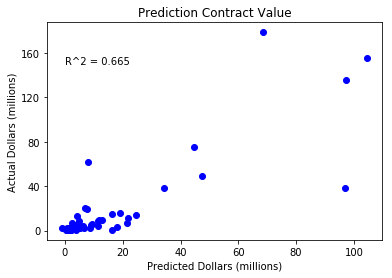

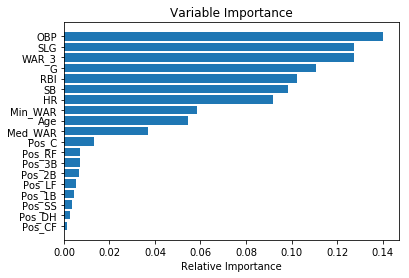

In [36]:
gbr_pos = GradientBoostingRegressor(max_depth = 3, n_estimators = 1000, learning_rate = 0.1)
gbr_pos_out = predictDollars(gbr_pos, X_pos, y_dollars_pos)

# Make a pretty plot
sorted_idx = np.argsort(gbr_pos_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbr_pos_out.feature_importances_[sorted_idx], align='center')
labels = [features_pos[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

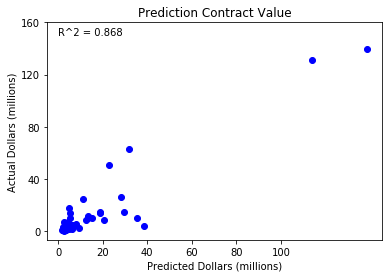

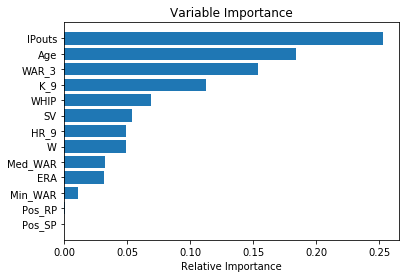

In [37]:
gbr_pitch = GradientBoostingRegressor(max_depth = 3, n_estimators = 5000, learning_rate = 0.001)
gbr_pitch_out = predictDollars(gbr_pitch, X_pitch, y_dollars_pitch)

# Make a pretty plot
sorted_idx = np.argsort(gbr_pitch_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbr_pitch_out.feature_importances_[sorted_idx], align='center')
labels = [features_pitch[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

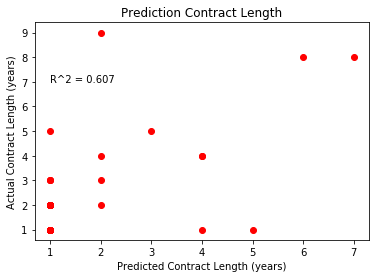

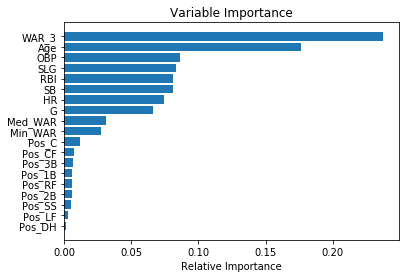

In [38]:
gbc_pos = GradientBoostingClassifier(max_depth = 3, n_estimators = 500, learning_rate = 0.01)
gbc_pos_out = predictLength(gbc_pos, X_pos, y_length_pos)

# Make a pretty plot
sorted_idx = np.argsort(gbc_pos_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbc_pos_out.feature_importances_[sorted_idx], align='center')
labels = [features_pos[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

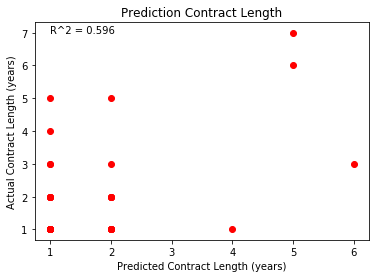

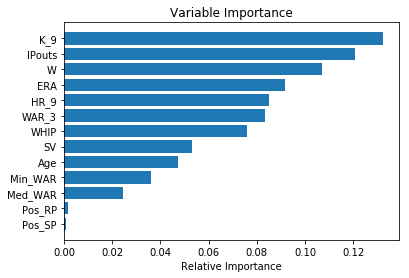

In [39]:
gbc_pitch = GradientBoostingClassifier(max_depth = 5, n_estimators = 1000, learning_rate = 0.01)
gbc_pitch_out = predictLength(gbc_pitch, X_pitch, y_length_pitch)

# Make a pretty plot
sorted_idx = np.argsort(gbc_pitch_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbc_pitch_out.feature_importances_[sorted_idx], align='center')
labels = [features_pitch[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Things the final model should do:

1. Take in a given year
2. Remove that year AND 2017 from the training data
3. For each player in that year, predict:
   1. Whether they will get a major league contract
   2. If "yes", length and total dollars of contract
       1. First, predict in 2006 dollars
       2. Then, grab the inflation table and translate to appropriate year's dollars
   3. If "no", fill in with N/A and 0 (or no major league contract)

In [118]:
import importlib
import models
models = importlib.reload(models)

In [119]:
with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
X_train, y_train, X_test, y_test = models.splitDataByYear(pitcher_prepped, 2014, 'pitcher')

In [120]:
pitcher_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033 entries, 0 to 1069
Data columns (total 25 columns):
Age                 1033 non-null int64
WAR_3               1033 non-null float64
nameFirst           1033 non-null object
nameLast            1033 non-null object
Year                1033 non-null int64
Dollars             529 non-null float64
Length              1033 non-null int64
playerID            1033 non-null object
yearID              1033 non-null int64
ERA                 1033 non-null float64
WHIP                1033 non-null float64
K_9                 1033 non-null float64
HR_9                1033 non-null float64
IPouts              1033 non-null float64
W                   1033 non-null float64
SV                  1033 non-null float64
Med_WAR             1033 non-null float64
Min_WAR             1033 non-null float64
Inflation_Factor    1033 non-null float64
Total               1033 non-null float64
Dollars_2006        529 non-null float64
Pos_RP              1033

In [121]:
contract_model, contract_preds = models.predictContract(X_train, y_train, X_test)

In [122]:
length_model, length_preds = models.predictLength(X_train, y_train, X_test)

In [123]:
dollars_model, dollars_preds = models.predictDollars(X_train, y_train, X_test) 

In [124]:
contract_model.score(X_test, y_test['Contract'])

0.77272727272727271

In [125]:
X_test_short = X_test[y_test.AAV_2006.notnull()]
y_test_short = y_test[y_test.AAV_2006.notnull()]
type(y_test_short)

pandas.core.frame.DataFrame

In [126]:
length_model.score(X_test_short, y_test_short['Length'])

0.66666666666666663

In [127]:
dollars_model.score(X_test_short, y_test_short['AAV_2006'])

0.76499797221359855

In [128]:
pitcher_prepped[pitcher_prepped.Year == 2016]['Inflation_Factor'].unique()[0]

1.6924528301886792

In [129]:
fa_year = 2006

# Load and prepare the datasets                                                                                                                                                             
#pitcher_all, position_all = models.loadAllData()
with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)

pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
position_prepped = models.prepareFreeAgentData(position_all)

# Use year to split dataset                                                                                                                                                                 
X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch = models.splitDataByYear(pitcher_prepped, fa_year, 'pitcher')
X_train_pos, y_train_pos, X_test_pos, y_test_pos = models.splitDataByYear(position_prepped, fa_year, 'position')

# Predict whether they'll get contracts                                                                                                                                                     
score_pitch, contract_pitch = models.predictContract(X_train_pitch, y_train_pitch, X_test_pitch)
_, contract_pos = models.predictContract(X_train_pos, y_train_pos, X_test_pos)

    # Predict contract length                                                                                                                                                                   
_, length_pitch = models.predictLength(X_train_pitch, y_train_pitch, X_test_pitch)
_, length_pos = models.predictLength(X_train_pos, y_train_pos, X_test_pos)

# Predict contract dollars                                                                                                                                                                  
_, dollars_pitch = models.predictDollars(X_train_pitch, y_train_pitch, X_test_pitch)
_, dollars_pos = models.predictDollars(X_train_pos, y_train_pos, X_test_pos) 

In [130]:
inflation_factor = pitcher_prepped[pitcher_prepped.Year == fa_year]['Inflation_Factor'].unique()[0]

test = pd.DataFrame({'nameFirst' : pitcher_prepped[pitcher_prepped.Year == fa_year]['nameFirst'].values,
              'nameLast' : pitcher_prepped[pitcher_prepped.Year == fa_year]['nameLast'].values,
              'position' : pitcher_all[pitcher_prepped.Year == fa_year]['Position'],
              'contract_pred' : contract_pitch,
              'contract_actual' : y_test_pitch['Contract'],
              'length_pred' : length_pitch,
              'length_actual': y_test_pitch['Length'],
              'dollars_pred' : np.round(dollars_pitch * length_pitch * inflation_factor, decimals = -5),
              'dollars_actual' : y_test_pitch['Dollars']})
test_small = test
test_small

,contract_actual,contract_pred,dollars_actual,dollars_pred,length_actual,length_pred,nameFirst,nameLast,position
0,False,False,NaN,2700000.0,0,1,Bruce,Chen,SP
1,True,True,3100000.0,3200000.0,1,1,Steve,Trachsel,SP
2,False,True,NaN,2600000.0,0,1,Mark,Redman,SP
3,True,False,3000000.0,4400000.0,1,1,David,Wells,SP
4,True,True,3500000.0,3000000.0,1,1,Tony,Armas,SP
5,False,False,NaN,1400000.0,0,1,Victor,Zambrano,SP
6,True,True,1500000.0,2100000.0,1,1,Tomo,Ohka,SP
7,True,False,3100000.0,3300000.0,1,1,Ramon,Ortiz,SP
8,True,False,500000.0,2100000.0,1,1,John,Thomson,SP
9,True,False,13000000.0,1900000.0,2,1,Mark,Mulder,SP


In [131]:
test_small['dollars_actual'] = test_small['dollars_actual'].apply(lambda x: '{:,.2f}'.format(x))
test_small['dollars_pred'] = test_small['dollars_pred'].apply(lambda x: '{:,.2f}'.format(x))
test_small['dollars_actual'].replace({'nan':'N/A'}, inplace = True)
test_small.loc[test_small.contract_pred == False,'dollars_pred'] = 'N/A'
test_small.loc[test_small.contract_pred == False,'length_pred'] = 0

In [132]:
test_small

,contract_actual,contract_pred,dollars_actual,dollars_pred,length_actual,length_pred,nameFirst,nameLast,position
0,False,False,N/A,N/A,0,0,Bruce,Chen,SP
1,True,True,"3,100,000.00","3,200,000.00",1,1,Steve,Trachsel,SP
2,False,True,N/A,"2,600,000.00",0,1,Mark,Redman,SP
3,True,False,"3,000,000.00",N/A,1,0,David,Wells,SP
4,True,True,"3,500,000.00","3,000,000.00",1,1,Tony,Armas,SP
5,False,False,N/A,N/A,0,0,Victor,Zambrano,SP
6,True,True,"1,500,000.00","2,100,000.00",1,1,Tomo,Ohka,SP
7,True,False,"3,100,000.00",N/A,1,0,Ramon,Ortiz,SP
8,True,False,"500,000.00",N/A,1,0,John,Thomson,SP
9,True,False,"13,000,000.00",N/A,2,0,Mark,Mulder,SP


# Making pretty graphs

In [207]:
import importlib
import models
models = importlib.reload(models)

fa_year = 2006

# Load and prepare the datasets                                                                                                                                                             
#pitcher_all, position_all = models.loadAllData()
with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)

pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
position_prepped = models.prepareFreeAgentData(position_all)

# Use year to split dataset                                                                                                                                                                 
X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch = models.splitDataByYear(pitcher_prepped, fa_year, 'pitcher')
X_train_pos, y_train_pos, X_test_pos, y_test_pos = models.splitDataByYear(position_prepped, fa_year, 'position')

# Predict whether they'll get contracts                                                                                                                                                     
contract_model_pitch, contract_pitch = models.predictContract(X_train_pitch, y_train_pitch, X_test_pitch)
contract_model_pos, contract_pos = models.predictContract(X_train_pos, y_train_pos, X_test_pos)

# Predict contract length                                                                                                                                                                   
length_model_pitch, length_pitch = models.predictLength(X_train_pitch, y_train_pitch, X_test_pitch)
length_model_pos, length_pos = models.predictLength(X_train_pos, y_train_pos, X_test_pos)

# Predict contract dollars                                                                                                                                                                  
dollars_model_pitch, dollars_pitch = models.predictDollars(X_train_pitch, y_train_pitch, X_test_pitch)
dollars_model_pos, dollars_pos = models.predictDollars(X_train_pos, y_train_pos, X_test_pos)

In [210]:
# Get shortened data sets
idx_pitch = y_test_pitch.AAV_2006.notnull()
X_test_short_pitch = X_test_pitch[idx_pitch]
y_test_short_pitch = y_test_pitch[idx_pitch]

idx_pos = y_test_pos.AAV_2006.notnull()
X_test_short_pos = X_test_pos[idx_pos]
y_test_short_pos = y_test_pos[idx_pos]

In [211]:
# Get scores for all 4
print('Pitching Scores:')
print(length_model_pitch.score(X_test_short_pitch, y_test_short_pitch['Length']))
print(dollars_model_pitch.score(X_test_short_pitch, y_test_short_pitch['AAV_2006']))
      
print('Position Scores:')
print(length_model_pos.score(X_test_short_pos, y_test_short_pos['Length']))
print(dollars_model_pos.score(X_test_short_pos, y_test_short_pos['AAV_2006']))  

Pitching Scores:
0.589285714286
0.625409042219
Position Scores:
0.603174603175
0.692034639146


In [212]:
# Write as a function
def calculateScoresForYear(fa_year):
    '''Take a year and get the R^2 for regression and Accuracy for classification'''
    
    # Load and prepare the datasets                                                                                                                                                             
    #pitcher_all, position_all = models.loadAllData()
    with open('pitching_data.pickle', 'rb') as file:
        pitcher_all = pickle.load(file)

    with open('position_data.pickle', 'rb') as file:
        position_all = pickle.load(file)

    pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
    position_prepped = models.prepareFreeAgentData(position_all)

    # Use year to split dataset                                                                                                                                                                 
    X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch = models.splitDataByYear(pitcher_prepped, fa_year, 'pitcher')
    X_train_pos, y_train_pos, X_test_pos, y_test_pos = models.splitDataByYear(position_prepped, fa_year, 'position')

    # Predict whether they'll get contracts                                                                                                                                                     
    contract_model_pitch, contract_pitch = models.predictContract(X_train_pitch, y_train_pitch, X_test_pitch)
    contract_model_pos, contract_pos = models.predictContract(X_train_pos, y_train_pos, X_test_pos)

    # Predict contract length                                                                                                                                                                   
    length_model_pitch, length_pitch = models.predictLength(X_train_pitch, y_train_pitch, X_test_pitch)
    length_model_pos, length_pos = models.predictLength(X_train_pos, y_train_pos, X_test_pos)

    # Predict contract dollars                                                                                                                                                                  
    dollars_model_pitch, dollars_pitch = models.predictDollars(X_train_pitch, y_train_pitch, X_test_pitch)
    dollars_model_pos, dollars_pos = models.predictDollars(X_train_pos, y_train_pos, X_test_pos)
    
    # Get shortened data sets
    idx_pitch = y_test_pitch.AAV_2006.notnull()
    X_test_short_pitch = X_test_pitch[idx_pitch]
    y_test_short_pitch = y_test_pitch[idx_pitch]

    idx_pos = y_test_pos.AAV_2006.notnull()
    X_test_short_pos = X_test_pos[idx_pos]
    y_test_short_pos = y_test_pos[idx_pos]

    # Get all 4 scores
    pitch_acc = length_model_pitch.score(X_test_short_pitch, y_test_short_pitch['Length'])
    pitch_r2 = dollars_model_pitch.score(X_test_short_pitch, y_test_short_pitch['AAV_2006'])
    pos_acc = length_model_pos.score(X_test_short_pos, y_test_short_pos['Length'])
    pos_r2 = dollars_model_pos.score(X_test_short_pos, y_test_short_pos['AAV_2006']) 
    
    return pitch_acc, pitch_r2, pos_acc, pos_r2

In [213]:
pitch_acc, pitch_r2, pos_acc, pos_r2 = calculateScoresForYear(2016)

In [214]:
pitch_accs = []
pitch_r2s = []
pos_accs = []
pos_r2s = []

for year in range(2006,2017):
    pitch_acc, pitch_r2, pos_acc, pos_r2 = calculateScoresForYear(year)
    pitch_accs.append(pitch_acc)
    pitch_r2s.append(pitch_r2)
    pos_accs.append(pos_acc)
    pos_r2s.append(pos_r2)

In [219]:
score_df = pd.DataFrame({'Year' : list(range(2006,2017)),
                         'Pitcher_Accuracy' : pitch_accs,
                         'Position_Accuracy' : pos_accs,
                         'Pitcher_Rsquared' : pitch_r2s,
                         'Position_Rsquared' : pos_r2s})
score_df.set_index('Year', inplace=True)

In [224]:
score_df

,Pitcher_Accuracy,Pitcher_Rsquared,Position_Accuracy,Position_Rsquared
Year,,,,
2006,0.625000,0.625409,0.619048,0.692035
2007,0.736842,0.572528,0.627907,0.870023
2008,0.660000,0.672233,0.603774,0.682461
2009,0.641026,0.473068,0.718310,0.423145
2010,0.647059,0.785346,0.622951,0.751046
2011,0.684211,0.616090,0.543860,0.793863
2012,0.500000,0.604585,0.581395,0.823463
2013,0.607843,0.537006,0.400000,0.780828
2014,0.595238,0.746959,0.638889,0.709932


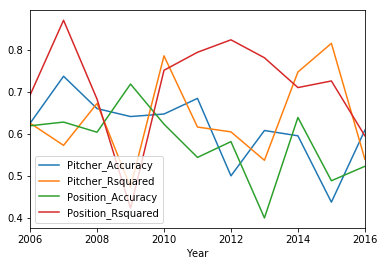

In [225]:
score_df.plot()
plt.show()